In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift, estimate_bandwidth
from shapely.geometry import Polygon
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt

#### DEFINE VARIABLES

In [2]:
PATH = 'data/radar/'
DAY = sorted(os.listdir(PATH))[0]

#### READ FIRST FILES TO LOAD GLOBAL VARIABLES

In [3]:
first_file = PATH+str(DAY)+'/'+str(sorted(os.listdir(PATH+str(DAY)))[0])
try:
    xds = xr.open_dataset(first_file)   
except Exception as e:
    print('File not found')
    
RUNIT = xds.rain_rate.units
RKM = xds.rain_rate.height_km
LON = xds.lon0.data                 ### Coordinate Longitude Matrix
LAT = xds.lat0.data                 ### Corrdinate Latitude Matrix
X0 = xds.x0                         ### Matrix of points
Y0 = xds.y0
RADAR = (np.median(LON),np.median(LAT))

#### READ TIMES

In [4]:
def read_data(date):
    
    path = 'data/radar/'
    dataset = []
    interval = len(os.listdir(path+str(date)))    
    
    # Original grid dimensions
    nx = 241
    ny = 241

    # Define container
    frames = np.zeros( (interval, nx, ny ) )    
    
    for i in range(interval):
        d = str(path)+str(date)+'/'
        file = (sorted(os.listdir(path+str(date)))[i])
        xds = xr.open_dataset(d+file)
        rr = xds.rain_rate
        frames[i] =  rr
            
    return frames

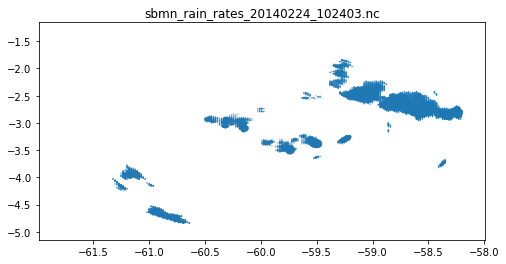

In [5]:
DAY = 20140224
figtime = 0
frames = read_data(DAY)

filename = sorted(os.listdir(PATH+str(DAY)))[figtime]
plt.figure(figsize=(8,4))
plt.title(filename)
plt.scatter(LON,LAT,frames[figtime])
plt.show();

In [445]:
def pre_processing(time):
    np.warnings.filterwarnings('ignore')
    
    ## thereshold value to track  21.8
    threshold = 10
    
    rs =  (np.where(time != np.nan) and np.where(time > threshold))
    rs = np.asanyarray(rs)
    pe = pd.DataFrame({'x1':rs[0],'y1':rs[1]})
        
    return pe

In [7]:
def mask(time):
    
    s = np.zeros((241, 241))
    
    for x in range(241):
        for y in range(241):
            if np.isnan(time[x][y]) != False:
                s[x][y] = np.nan
    return s

In [446]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

def dbscan(time):
    
    X = time

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # cluster the data into five clusters
    dbscan = DBSCAN(eps=0.1)
    clusters = dbscan.fit_predict(X_scaled)
    labels = dbscan.labels_
    
    time['cluster'] = labels
    time = time[(time['cluster'] >= 0)]
    
    return time

In [447]:
day = DAY
time = 15
frames = read_data(day)
clusters = dbscan(pre_processing(frames[time]))
clusters.head()

,x1,y1,cluster
0,105,160,0
1,105,162,0
2,105,163,0
3,105,164,0
4,105,165,0


In [448]:
def clusterization(time):
    te = time
    
    if len(te) < 2:
        return None
    
    bandwidth = estimate_bandwidth(te, quantile=0.1, n_samples=None, random_state=0, n_jobs=None)

    # first clusterization
    if bandwidth > 0:
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=None, cluster_all=True, min_bin_freq=1,
        n_jobs=None, seeds=None)

    ms.fit(te)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters_ = len(np.unique(labels))
    te['cluster']=labels

    clust = pd.DataFrame()
    
    for i in range(n_clusters_):
        c2 = te.loc[te['cluster'] == i]
        c3 = ms2(c2[['x1','y1']])
        clust = clust.append(c3)
    
    clust['label1'] = te['cluster']
    clust = clust.reset_index(drop=True)
               
    return te

In [449]:
def ms2(time2):
    ms = MeanShift(bandwidth=3, bin_seeding=None, cluster_all=True, min_bin_freq=1,
    n_jobs=None, seeds=None)

    ms.fit(time2)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters_ = len(np.unique(labels))
    time2['label2']=labels

    return time2

In [450]:
day = DAY
time = 15
frames = read_data(day)
clusters = clusterization(pre_processing(frames[time]))
clusters.head()

,x1,y1,cluster
0,105,160,6
1,105,162,6
2,105,163,6
3,105,164,6
4,105,165,6


In [451]:
# clusters.label1.iloc[0:3] = clusters.iloc[0:3].label1+1
# clusters.loc[clusters['label1'] == 1].sort_values('label2')

In [452]:
def create_data(day,time,frames,clusters):
    
    data = pd.DataFrame(columns=['DATETIME', 'N_CLUSTER','ID_CLUST','LON','LAT','R_FALL','DBZ'])

    # get values datetime
    dtime = xr.open_dataset(str(PATH)+str(day)+'/'+str(sorted(os.listdir(PATH+str(day)))[time])).start_time.values
    
    lat = (LAT[clusters['x1'],clusters['y1']])
    lon = (LON[clusters['x1'],clusters['y1']])
    
    # get values from RAIN_FALL
    rfall = (frames[clusters['x1'],clusters['y1']])
    
    data['LON'] = lon
    data['LAT'] = lat
    
    data['N_CLUSTER'] = len(clusters['cluster'].unique())
    data['ID_CLUST'] = clusters['cluster']
    data['X1'] = clusters['x1']
    data['Y1'] = clusters['y1']
    data['R_FALL'] = rfall
    data['DBZ'] = 10 * np.log10(200*data['R_FALL']**1.6)
    data['DATETIME'] = pd.to_datetime(dtime)
    
    data = data.set_index('DATETIME')
    
    # get 5 largest values from DBZ
    largest = 3
    cdata = pd.DataFrame()
    for i in range(data['N_CLUSTER'].max()):
        ct = data.loc[data['ID_CLUST'] == i]
        if ct.ID_CLUST.count() >= 3:
            cdata = cdata.append(ct)
            
    cdata['N_CLUSTER'] = len(cdata['ID_CLUST'].unique())
    cdata['ID_CLUST'] = cdata['ID_CLUST'].astype(int)
    
    del data,dtime,lat,lon,rfall,largest,ct
    
    return cdata

In [453]:
day = DAY
time = 11
frames = read_data(day)
clusters = clusterization(pre_processing(frames[time]))
# clusters = dbscan(pre_processing(frames[time]))

In [454]:
data = create_data(day,time,frames[time],clusters)
data.head()

,N_CLUSTER,ID_CLUST,LON,LAT,R_FALL,DBZ,X1,Y1
DATETIME,,,,,,,,
2014-02-24 12:36:06,10,0,-59.974022,-2.268951,11.823426,40.174194,169,121
2014-02-24 12:36:06,10,0,-59.920082,-2.268949,10.495256,39.346189,169,124
2014-02-24 12:36:06,10,0,-59.902111,-2.143183,11.094495,39.732020,176,125
2014-02-24 12:36:06,10,0,-59.884132,-2.143182,11.090142,39.729294,176,126
2014-02-24 12:36:06,10,0,-59.866154,-2.143180,12.245173,40.417739,176,127


In [455]:
data['geometry'] = list(zip(data.LON,data.LAT))
data.geometry = data.geometry.apply(Point)
gdata = gpd.GeoDataFrame(data,geometry='geometry')
gdata.crs = {'init' :'epsg:4326'}
gdata.to_file('shapefiles/points.shp')
gdata.head()

,N_CLUSTER,ID_CLUST,LON,LAT,R_FALL,DBZ,X1,Y1,geometry
DATETIME,,,,,,,,,
2014-02-24 12:36:06,10,0,-59.974022,-2.268951,11.823426,40.174194,169,121,POINT (-59.97402191162109 -2.268950939178467)
2014-02-24 12:36:06,10,0,-59.920082,-2.268949,10.495256,39.346189,169,124,POINT (-59.92008209228516 -2.268948793411255)
2014-02-24 12:36:06,10,0,-59.902111,-2.143183,11.094495,39.732020,176,125,POINT (-59.9021110534668 -2.143183469772339)
2014-02-24 12:36:06,10,0,-59.884132,-2.143182,11.090142,39.729294,176,126,POINT (-59.88413238525391 -2.143182039260864)
2014-02-24 12:36:06,10,0,-59.866154,-2.143180,12.245173,40.417739,176,127,POINT (-59.86615371704102 -2.143180131912231)


In [456]:
from shapely import wkt
def geo_data(cdata):
 
    cdata['geometry'] = list(zip(cdata.LON,cdata.LAT))
    cdata.geometry = cdata.geometry.apply(Point)
    cdata['geometry'] = cdata['geometry'].apply(lambda x: x.coords[0])
    cdata = cdata.groupby('ID_CLUST')['geometry'].apply(lambda x: Polygon(x.tolist()))
    cdata = gpd.GeoDataFrame(cdata, geometry = 'geometry')
    cdata.crs = {'init' :'epsg:4326'}
    return cdata

gdata = geo_data(data)
gdata['geometry'] = gdata.geometry.exterior

gdata.geometry.convex_hull.to_file('shapefiles/polygon.shp')
gdata.geometry.centroid.to_file('shapefiles/centroid.shp')
gdata.head()

,geometry
ID_CLUST,
0,LINEARRING (-59.97402191162109 -2.268950939178...
1,LINEARRING (-59.63210678100586 -3.221102952957...
2,LINEARRING (-59.03829574584961 -3.202761173248...
3,LINEARRING (-60.02797317504883 -2.736074447631...
4,LINEARRING (-59.83009338378906 -2.915725946426...


### CREATE TIFF FILE

In [457]:
#!/usr/bin/env python
from osgeo import gdal
from osgeo import osr
import numpy as np
import os, sys

#  Initialize the Image Size
image_size = (241,241)

lat = [-5.348556,-0.948556]
lon = [-62.192,-57.7919999]
            
# set geotransform
nx = image_size[0]
ny = image_size[1]
xmin, ymin, xmax, ymax = [min(lon), max(lat), max(lon), min(lat)]
# xmin, ymin, xmax, ymax = [min(lon), min(lat), max(lon), max(lat)]
xres = (xmax - xmin) / float(nx)
yres = (ymax - ymin) / float(ny)
geotransform = (xmin, xres, 0, ymax, 0, -yres)

# create the 3-band raster file
dst_ds = gdal.GetDriverByName('GTiff').Create('tiff/myGeoTIFF.tif', ny, nx, 1, gdal.GDT_Float64)

dst_ds.SetGeoTransform(geotransform)    # specify coords
srs = osr.SpatialReference()            # establish encoding
srs.ImportFromEPSG(4326)                # WGS84 lat/long
dst_ds.SetProjection(srs.ExportToWkt()) # export coords to file
dst_ds.GetRasterBand(1).WriteArray(frames[time])   # write a-band to the raster
dst_ds.FlushCache()                     # write to disk
dst_ds = None

### PLOT

In [458]:
import georaster
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as mcolors
import cartopy as cartopy
from matplotlib import cm, pyplot
from matplotlib import markers

In [459]:
def plot(frame,day,zoom):
    
    fpath = r"tiff/myGeoTIFF.tif"
    my_image = georaster.SingleBandRaster(fpath, load_data=True)
    
    # grab limits of image's extent
    minx, maxx, miny, maxy = my_image.extent

    image = georaster.SingleBandRaster( fpath, \
                        load_data=(minx, maxx, miny, maxy), \
                        latlon=False)
        
    file = PATH+str(day)+'/'+str(sorted(os.listdir(PATH+str(day)))[frame])
    xds = xr.open_dataset(file)
    date_time = xds.start_time.data
    date_time = pd.to_datetime(date_time)

    my_coords = [-3.148556, -59.992000]     ## RADAR T1 SIPAM COORDS
    zoom_scale = zoom                        ## ZOOM SCALE

    bbox = [my_coords[0]-zoom_scale,my_coords[0]+zoom_scale,\
             my_coords[1]-zoom_scale,my_coords[1]+zoom_scale]

    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,10),dpi=100)
    label = 'Rain fall mm/h'
    title = 'SIPAM Manaus S-Band Radar :' + str(date_time)
    
    clevs = [0,1,2.5,5,10,20,30,40,50,60,70,80,90,100]

    cmap_data = ['white','deepskyblue','dodgerblue','dodgerblue','dodgerblue','blue','chartreuse','limegreen','green','darkgreen','yellow',
             'gold','orange','magenta','darkmagenta','darkmagenta']

    cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    norm = mcolors.BoundaryNorm(clevs, cmap.N)
    ax = axes

    m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
                    llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
    
    b = m.readshapefile('./shapefiles/centroid', 'centroids')
    c = m.readshapefile('./shapefiles/municipios/AM_Mun97_region', 'municipios', linewidth=0.1)
    d = m.readshapefile('./shapefiles/hidro/lineaire_1km', 'hidrografia',color='deepskyblue', linewidth=1)


    ## SIPAM RADAR
    xm, ym = m(my_coords[1],my_coords[0])
    radar = m.plot(xm,ym, marker='o',color='k', label='RADAR')

    f = m.plot(0,0, marker='v',color='red', label='Centroids '+str(b[0]), markersize=8)

    ## PRECIPTACAO
    xi, yi = m(LON, LAT)
    levels = np.arange(0,100,1)
    clevels = np.arange(10,100,50)
    cs = m.contourf(xi,yi,image.r,levels=levels, cmap = cmap, norm = norm, ax=ax)
    cs2 = m.contour(xi,yi,image.r,levels=clevels,  ax=ax)
    
    arrowprops = dict(facecolor='red', arrowstyle="fancy",
                            ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90")
    
    for info, s in zip(m.centroids, m.centroids):    
        ax.annotate(' ', xy=(info[0],info[1]), xytext=(info[0],info[1]),
            arrowprops=arrowprops, size=20, color='k')

    # # # # Add Grid Lines
    m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0],rotation=45, size=(10))
    m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45, size=(10))
    m.drawmapboundary(fill_color='gray')

    # # # # Add Colorbar
    cbar = m.colorbar(cs, size='5%',pad="2%")
    cbar.set_label(label)

    # # # # # Add Title
    plt.title(title)
    plt.legend()
    plt.ylabel('Longitude', labelpad=40, fontsize=15)
    plt.xlabel('Latitude', labelpad=60, fontsize=15)

    plt.savefig('radar_image/'+ sorted(os.listdir(PATH+str(day)))[frame]+'.png')

    plt.show()

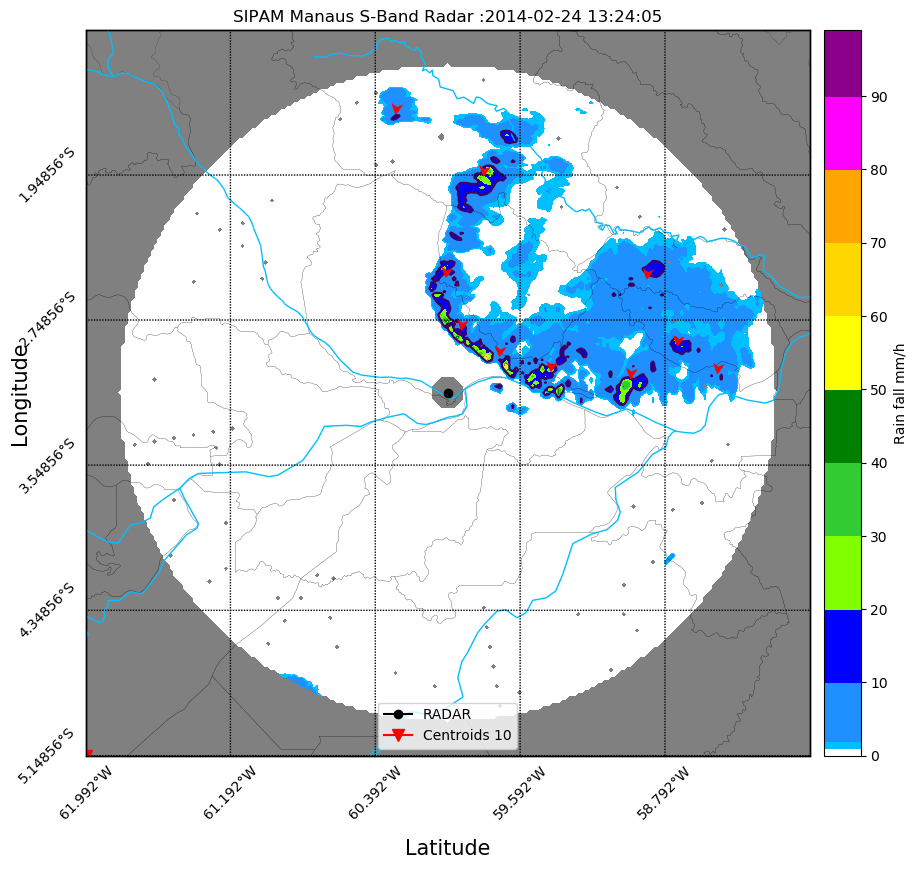

In [460]:
day = 20140224
plot(15,day,2)